In [195]:
import torch
from torch.autograd import Variable
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Introduction

Let's say y = f(x_1, x_2, ..., x_n)
If f is a mathematical function of x_1, x_2, x_3, ..., x_n then we can wire up a neural network to try to find this function given some examples of (x_1, x_2, ...., x_n, y) 

# 1st: Normal Equation Method

In [323]:
# Let's try to find the equation y = 2 * x 
# We have 6 examples:- (x,y) = (0.1,0.2), (1,2), (2, 4), (3, 6), (-4, -8), (25, 50)
# Let's assume y is a linear combination of the features x, x^2, x^3
# We know that Normal Equation gives us the exact solution so let's first use that

N = 6
x = np.array([0.1, 1, 2, 3, -4, 25])
y = np.array([0.2, 2, 4, 6, -8, 50])
x_2 = x**2
x_3 = x**3

X = np.ones((N, 4))
X[:,1] = x
X[:,2] = x_2
X[:,3] = x_3

_, D = np.shape(X)
regularization_strength = 0.0
XtX = (X.T).dot(X)
I = np.eye(D, dtype=float)
XtX_RI = XtX + regularization_strength*I
XtY = (X.T).dot(y)
w = np.linalg.solve(XtX_RI, XtY)
y_pred = X.dot(w)
loss = np.sqrt(np.mean((y_pred-y)**2))
# As expected w ~ [0 2 0 0]
print("W : ", w)
print("Predicted Y : ", y_pred)
print("RMS loss : ", loss)

W :  [ -1.49279111e-14   2.00000000e+00   2.43350714e-15  -1.04209881e-16]
Predicted Y :  [  0.2   2.    4.    6.   -8.   50. ]
RMS loss :  1.1242258769e-14


# 2nd: Neural Network Approach

In [453]:
# Setup the training and test tensors
# Let's generate 400 examples
N = 400
x = np.random.uniform(low=-75, high=100, size=N)
y = 2*x
X = np.zeros((N, 3))
X[:,0] = x
X[:,1] = x**2
X[:,2] = x**3

X_tensor = Variable(torch.FloatTensor(X), requires_grad=False)
y_tensor = Variable(torch.FloatTensor(y), requires_grad=False)

# Test set initialization
X_test = np.zeros((3, 3))
X_test[:,0] = np.array([-2.5, 0.0, 19])
X_test[:,1] = X_test[:,0]**2
X_test[:,2] = X_test[:,0]**3
X_test_tsr = Variable(torch.FloatTensor(X_test), requires_grad=False)

In [500]:
# A simple linear Neural Net which is y = w_1*x + w_2*x^2 + w_3*x^3 + b
import math

def RunLinearNNTraining(X, y, learning_rate=1e-5, epochs=5000, batch_size=None, X_test=None, use_optimizer=None):
    
    # Neural Net
    X_size = X.size()
    N = X_size[0]
    D_in = X_size[1]
    D_out = 1
    model = torch.nn.Linear(D_in, D_out)
    loss_fn = torch.nn.MSELoss(size_average=True)
    
    # Choose Optimizer
    optimizer = None
    if use_optimizer:
        if use_optimizer == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'ASGD':
            optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        else:
            print("Invalid Optimizer")
            use_optimizer=None
    
    losses = []
    loss = None
    for t in range(epochs):
        num_batches = 1
        X_batch = None
        y_batch = None
        if batch_size:
            num_batches = math.ceil(N/batch_size)
        else:
            batch_size = N
        
        shuffle = torch.randperm(N)
        
        for b in range(num_batches):
            lower_index = b*batch_size
            upper_index = min(lower_index+batch_size, N)
            indices = shuffle[lower_index:upper_index]
            X_batch = X[indices]
            y_batch = y[indices]
                        
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.data[0])
            
            if use_optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # Zero the gradients before running the backward pass.
                model.zero_grad()
                loss.backward()

                # Update the weights using gradient descent. Each parameter is a Variable, so
                # we can access its data and gradients like we did before.
                for param in model.parameters():
                    param.data -= learning_rate * param.grad.data

    print("Final Loss: ", loss.data[0])
    print("Parameters [w_1, w_2, w_3, b]: ")
    for param in model.parameters():
        print(param.data[0])

    # plot Loss vs Iterations
    plt.plot(losses)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    # Predictions on Test set
    if X_test:
        print("Test:")
        print("X_test: ", X_test.data)
        print("y_pred: ", model(X_test))

## Full batch gradient descent
### SGD:
It doesn't converge to global optima and the learning rate has to be set very low if not the gradients explode.
### Adam and RMSprop:
It needs a lot of epochs to converge close to global optima.

Final Loss:  0.014629274606704712
Parameters [w_1, w_2, w_3, b]: 

 1.9988e+00
-5.3303e-05
 4.9020e-07
[torch.FloatTensor of size 3]

0.18852441012859344


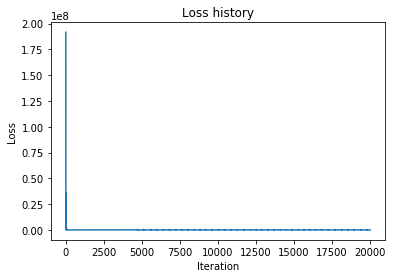

Test:
X_test:  
   -2.5000     6.2500   -15.6250
    0.0000     0.0000     0.0000
   19.0000   361.0000  6859.0000
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
 -4.8088
  0.1885
 38.1494
[torch.FloatTensor of size 3x1]



In [515]:
# use_optimizer can be Adam, RMSprop, Adadelta, ASGD, SGD
RunLinearNNTraining(X=X_tensor, y=y_tensor, batch_size=None, epochs=20000, learning_rate=1e-2, 
                    X_test=X_test_tsr, use_optimizer='Adam')

## Full batch gradient descent with feature normalization

Variable containing:
 2599.5002   109.1683     4.5167
[torch.FloatTensor of size 1x3]

Variable containing:
 15689.0000    624.9900     29.0000
[torch.FloatTensor of size 1x3]

Variable containing:
-0.1657 -0.1747 -0.1523
-0.1656 -0.1731 -0.1213
-0.1652 -0.1683 -0.0868
-0.1640 -0.1603 -0.0523
-0.1698 -0.1491 -0.2937
 0.8302  0.8253  0.7063
[torch.FloatTensor of size 6x3]

Variable containing:
 -0.3033
 -0.3688
 -1.1180
 -2.4675
 -9.6742
 50.0109
[torch.FloatTensor of size 6x1]

Final Loss:  17.759979248046875

 0.0193 -0.4158  0.3632
[torch.FloatTensor of size 1x3]


-0.3355
[torch.FloatTensor of size 1]



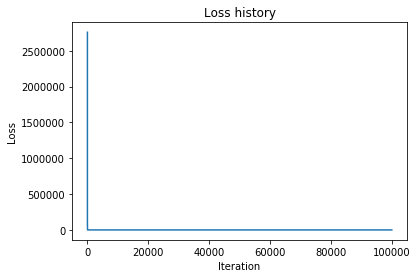

In [298]:
# Let's try to find the equation y = 2 * x
# We have 7 examples:- (x,y) = (0.1,0.2), (1,2), (2, 4), (3, 6), (-4, -8), (2.5, 5.0), (0, 0), (-2.5, -5.0)
N = 6
D_in = 1
D_out = 1
X_tensor = Variable(torch.FloatTensor(x), requires_grad=False)
x = Variable(torch.FloatTensor([0.1, 1, 2, 3, -4, 25]), requires_grad=False).view(N,D_in)
y = Variable(torch.FloatTensor([0.2, 2, 4, 6, -8, 50]), requires_grad=False).view(N,D_in)
x_test = torch.FloatTensor([2.5, 0, -2.5]).view(-1,1)
y_test = torch.FloatTensor([5, 0, -5]).view(-1,1)

x_3 = torch.pow(x,3)
x_2 = torch.pow(x,2)
X = torch.cat([x_3, x_2, x], 1)
X_min = torch.min(X,0)
X_max = torch.max(X,0)
X_mean = torch.mean(X,0)
X_sub_mean = X-X_mean.expand_as(X)
X_max_sub_min = X_max[0]-X_min[0] + 1e-7
print(X_mean)
print(X_max_sub_min)
X_transformed = X_sub_mean/X_max_sub_min.expand_as(X_sub_mean)
print(X_transformed)
D_in = 3

# Let's assume, y = w_1*x^3 + w_2*x^2 + w_3*x + b
model = torch.nn.Linear(D_in, D_out)
loss_fn = torch.nn.MSELoss(size_average=True)
l1 = torch.nn.L1Loss(size_average=True)
learning_rate = 1e-8
regularization_strength = 0.01
losses = []
y_pred = None
loss = None
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(100000):
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    reg_loss = 0
    for param in model.parameters():
        size= param.size()
        reg_loss += l1(param, Variable(torch.zeros(size), requires_grad=False))
    #loss += regularization_strength * reg_loss
    #print(t, loss.data[0])
    losses.append(loss.data[0])

    # Zero the gradients before running the backward pass.
    model.zero_grad()
    #optimizer.zero_grad()

    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Variable, so
    # we can access its data and gradients like we did before.
    #optimizer.step()
    for param in model.parameters():
        #print(param.grad.data)
        param.data -= learning_rate * param.grad.data

print(y_pred)
print("Final Loss: ", loss.data[0])
for param in model.parameters():
    print(param.data)

plt.plot(losses)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# w = [0 0 58], b = 9.0334

In [ ]:
reg = 0.1
lr = 1e-5
w = Variable(torch.randn(3), requires_grad=True)
b = Variable(torch.zeros(1), requires_grad=True)
x_3 = torch.pow(x,3)
x_2 = torch.pow(x,2)
X = torch.cat([x_3, x_2, x], 1)
print(X)
losses = []
# Use autograd to compute the backward pass.
for i in range(10000):
    WX = X.mm(w.view(3,1))
    output = WX + b.expand_as(WX)
    loss = (y-output).pow(2).mean().sqrt() + torch.abs(w).sum()
    losses.append(loss.data[0])
    #print("Iteration ", i, " : ", loss.data)
    
    loss.backward(retain_variables=True)
    # Update weights using gradient descent
    #print(w)
    #print(output)
    #print(w.grad.data)
    #print(b.grad.data)
    w.data -= lr * w.grad.data
    b.data -= lr * b.grad.data

    # Manually zero the gradients after updating weights
    w.grad.data.zero_()
    b.grad.data.zero_()
    
print(w)
print(b)
WX = X.mm(w.view(3,1))
output = WX + b.expand_as(WX)
loss = (y-output).pow(2).mean().sqrt() + torch.abs(w).sum()
print(output)
print(loss)
plt.plot(losses)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()